# Customer Clustering Analysis
This notebook builds the clustering component for the SI 671 final project by preparing the e-commerce dataset, training clustering models, and summarizing resulting customer segments.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
#import umap.umap_ as umap

plt.style.use("seaborn-v0_8")


In [2]:
DATA_PATH = "Ecommerce_Consumer_Behavior_Analysis_Data.csv"

df_raw = pd.read_csv(DATA_PATH)
print(f"Rows: {df_raw.shape[0]}, Columns: {df_raw.shape[1]}")
df_raw.head()


Rows: 1000, Columns: 28


,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


In [3]:
df = df_raw.copy()

df["Purchase_Amount"] = (
    df["Purchase_Amount"]
    .replace({"\$": "", ",": ""}, regex=True)
    .str.strip()
    .astype(float)
)

to_force_numeric = [
    "Age",
    "Frequency_of_Purchase",
    "Brand_Loyalty",
    "Product_Rating",
    "Time_Spent_on_Product_Research(hours)",
    "Return_Rate",
    "Customer_Satisfaction",
    "Time_to_Decision",
]

for col in to_force_numeric:
    df[col] = pd.to_numeric(df[col], errors="coerce")

numeric_features = [
    "Age",
    "Purchase_Amount",
    "Frequency_of_Purchase",
    "Brand_Loyalty",
    "Product_Rating",
    "Time_Spent_on_Product_Research(hours)",
    "Return_Rate",
    "Customer_Satisfaction",
    "Time_to_Decision",
]

categorical_features = [
    "Gender",
    "Income_Level",
    "Marital_Status",
    "Occupation",
    "Purchase_Category",
    "Purchase_Channel",
    "Social_Media_Influence",
    "Discount_Sensitivity",
    "Customer_Loyalty_Program_Member",
    "Discount_Used",
    "Purchase_Intent",
    "Shipping_Preference",
    "Device_Used_for_Shopping",
    "Payment_Method",
]

feature_df = df[numeric_features + categorical_features]
feature_df.head()


,Age,Purchase_Amount,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision,Gender,...,Purchase_Category,Purchase_Channel,Social_Media_Influence,Discount_Sensitivity,Customer_Loyalty_Program_Member,Discount_Used,Purchase_Intent,Shipping_Preference,Device_Used_for_Shopping,Payment_Method
0,22,333.80,4,5,5,2.0,1,7,2,Female,...,Gardening & Outdoors,Mixed,NaN,Somewhat Sensitive,False,True,Need-based,No Preference,Tablet,Credit Card
1,49,222.22,11,3,1,2.0,1,5,6,Male,...,Food & Beverages,In-Store,Medium,Not Sensitive,False,True,Wants-based,Standard,Tablet,PayPal
2,24,426.22,2,5,5,0.3,1,7,3,Female,...,Office Supplies,Mixed,Low,Not Sensitive,True,True,Impulsive,No Preference,Smartphone,Debit Card
3,29,101.31,6,3,1,1.0,0,1,10,Female,...,Home Appliances,Mixed,High,Somewhat Sensitive,True,True,Need-based,Express,Smartphone,Other
4,33,211.70,6,3,4,0.0,2,10,4,Female,...,Furniture,Mixed,Medium,Not Sensitive,False,False,Wants-based,No Preference,Smartphone,Debit Card


In [4]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X = preprocessor.fit_transform(feature_df)
if hasattr(X, "toarray"):
    X = X.toarray()

feature_names = preprocessor.get_feature_names_out()

print(f"Transformed feature matrix shape: {X.shape}")


Transformed feature matrix shape: (1000, 77)


In [5]:
df_clusters = df.copy()

representative_cats = [
    "Purchase_Channel",
    "Purchase_Intent",
    "Device_Used_for_Shopping",
    "Discount_Sensitivity",

    "Gender",
    "Income_Level",
    "Marital_Status",
    "Occupation",
    "Social_Media_Influence",
    "Discount_Used",
    "Payment_Method",
]


def mode_label(series: pd.Series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else np.nan


def summarize_clusters(label_col: str):
    if label_col not in df_clusters:
        print(f"Column {label_col} not found.")
        return
    numeric_summary = df_clusters.groupby(label_col)[numeric_features].mean().round(2)
    categorical_summary = df_clusters.groupby(label_col)[representative_cats].agg(mode_label)
    display(numeric_summary)
    display(categorical_summary)


def plot_embedding_scatter(embedding: np.ndarray, labels: np.ndarray, title: str):
    if labels is None:
        print(f"Skipping {title}: labels not available.")
        return
    plot_df = pd.DataFrame(embedding, columns=["Dim1", "Dim2"])
    plot_df["cluster"] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=plot_df,
        x="Dim1",
        y="Dim2",
        hue="cluster",
        palette="Set2",
        alpha=0.7,
    )
    plt.title(title)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


### t-SNE Embedding + K-Means Clustering


In [6]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca", random_state=42)
tsne_embedding = tsne.fit_transform(X)
print(f"t-SNE embedding shape: {tsne_embedding.shape}")


t-SNE embedding shape: (1000, 2)


,k,silhouette
0,2,0.349303
1,3,0.371238
2,4,0.353614
3,5,0.337493
4,6,0.317058
5,7,0.302012
6,8,0.340344


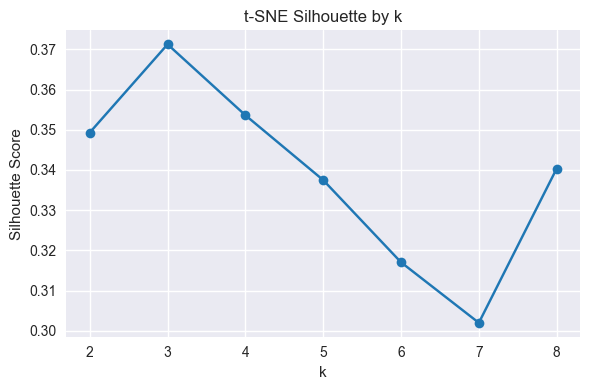

Best k on t-SNE space: 3


In [7]:
tsne_eval_records = []

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(tsne_embedding)
    tsne_eval_records.append(
        {
            "k": k,
            "silhouette": silhouette_score(tsne_embedding, labels),
        }
    )

tsne_eval_df = pd.DataFrame(tsne_eval_records)
display(tsne_eval_df)

plt.figure(figsize=(6, 4))
plt.plot(tsne_eval_df["k"], tsne_eval_df["silhouette"], marker="o", color="tab:blue")
plt.title("t-SNE Silhouette by k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k_tsne = int(tsne_eval_df.loc[tsne_eval_df["silhouette"].idxmax(), "k"])
print(f"Best k on t-SNE space: {best_k_tsne}")

tsne_kmeans = KMeans(n_clusters=best_k_tsne, random_state=42, n_init="auto")
tsne_labels = tsne_kmeans.fit_predict(tsne_embedding)
df_clusters["tsne_cluster"] = tsne_labels


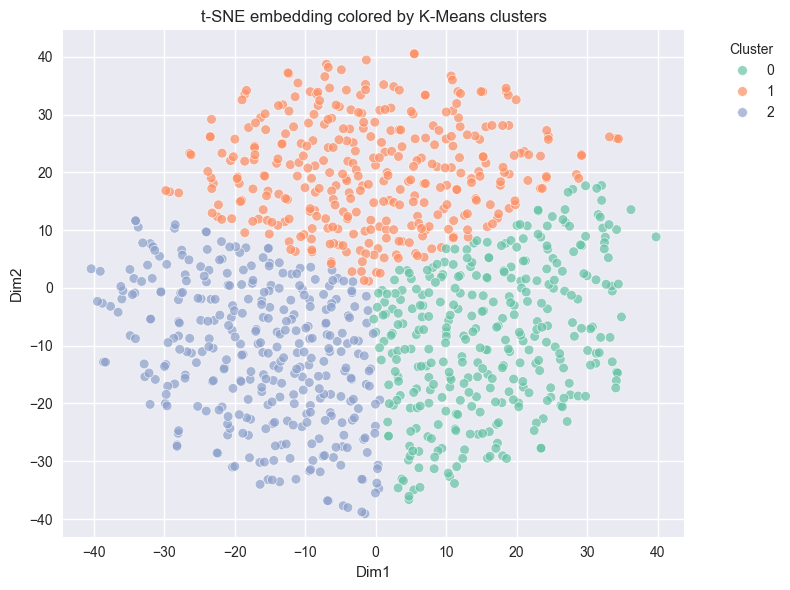

,Age,Purchase_Amount,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision
tsne_cluster,,,,,,,,,
0,30.58,280.28,6.87,3.33,2.83,0.52,0.99,4.48,7.59
1,34.89,279.32,7.90,2.98,3.58,1.46,1.14,4.53,8.83
2,37.39,265.55,6.04,2.77,2.67,1.04,0.73,7.19,6.19


,Purchase_Channel,Purchase_Intent,Device_Used_for_Shopping,Discount_Sensitivity,Gender,Income_Level,Marital_Status,Occupation,Social_Media_Influence,Discount_Used,Payment_Method
tsne_cluster,,,,,,,,,,,
0,Online,Need-based,Desktop,Very Sensitive,Female,High,Widowed,High,Medium,True,Debit Card
1,In-Store,Impulsive,Desktop,Not Sensitive,Male,High,Divorced,Middle,Low,False,PayPal
2,Mixed,Wants-based,Tablet,Somewhat Sensitive,Male,Middle,Widowed,High,High,True,Credit Card


In [8]:
plot_embedding_scatter(tsne_embedding, tsne_labels, "t-SNE embedding colored by K-Means clusters")
summarize_clusters("tsne_cluster")


## t-SNE Cluster Insights (k = 3, silhouette = 0.37)

### Cluster 0 – Agile Online Deal Seekers (328 customers)

- Avg. age 30.6; mostly female, high-income.

- Heavy focus on Sports & Outdoors, bought online with need-based decision making.

- Purchase frequency 6.9, loyalty 3.3, but the lowest product rating (2.8) and satisfaction (4.5).

- Very short research time (0.5 hrs) and quick decisions (7.6 days), low return rate.

- High discount sensitivity, medium social-media influence; not in loyalty programs but frequently redeems discounts.

- debit card preferred. Ideal targets for online flash deals and bundle offers that address low satisfaction.

### Cluster 1 – High-Value Offline Impulsives (340 customers)

- Avg. age 34.9; mostly male, high-income, occupation “Middle.”

- Purchase “Packages” bundles in-store; impulsive purchase intent.

- Highest purchase frequency (7.9) and longest decision cycle (8.8 days), with more extensive research (1.46 hrs).

- Low social-media influence, discount-insensitive, rarely in loyalty programs, and seldom use coupons; demands express shipping.

- Desktop + PayPal payment. Suited for in-store experiential marketing, limited-time offers, and premium fulfillment perks.

### Cluster 2 – Omnichannel Loyalists (332 customers)

- Avg. age 37.4; mostly male, middle-income, occupation “High.”

- Electronics shoppers who mix online and offline channels; wants-based intent.

- Lowest purchase frequency (6.0) but highest satisfaction (7.2) and the fastest decision time (6.2 days).

- High social-media influence, somewhat discount-sensitive, active loyalty members who redeem coupons regularly.

- Tablet + credit card usage, standard shipping preference. Perfect for omnichannel loyalty upgrades, cross-sell campaigns, and advocacy programs.